In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import scipy

In [3]:
samplerate_one, one = wavfile.read('sounds/one.wav')
samplerate_two, two = wavfile.read('sounds/two.wav')

print('Sampling Rate #1 and #2:', samplerate_one, samplerate_two)
print('Audio Shape #1 and #2:', np.shape(one), np.shape(two))

Sampling Rate #1 and #2: 48000 48000
Audio Shape #1 and #2: (46080,) (53248,)


In [4]:
sd.play(one, samplerate_one)
sd.wait()

sd.play(two, samplerate_two)
sd.wait()

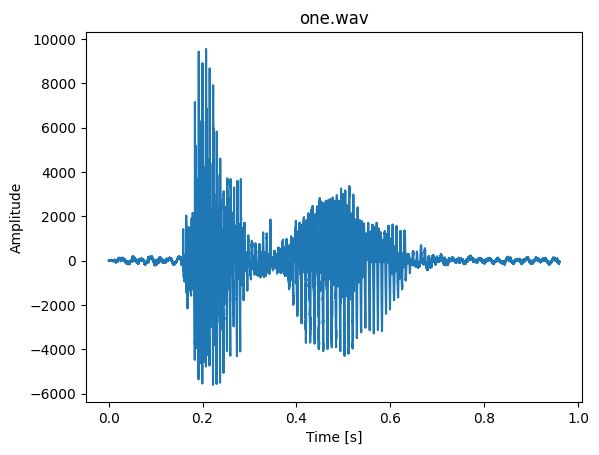

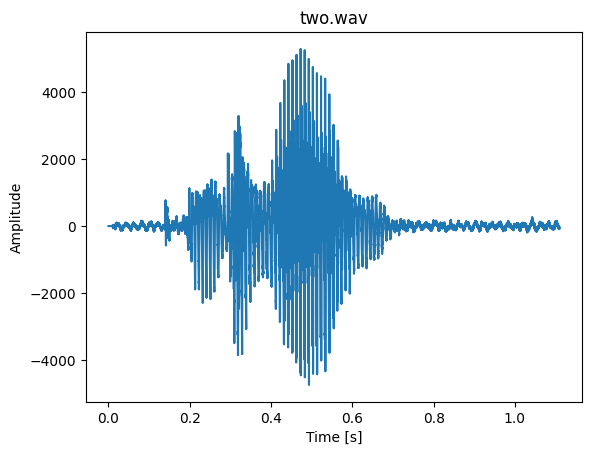

In [5]:
duration = len(one) / samplerate_one
time = np.arange(0, duration, 1 / samplerate_one)

plt.plot(time, one)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('one.wav')
plt.show()

duration = len(two) / samplerate_two
time = np.arange(0, duration, 1 / samplerate_two)

plt.plot(time, two)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('two.wav')
plt.show()

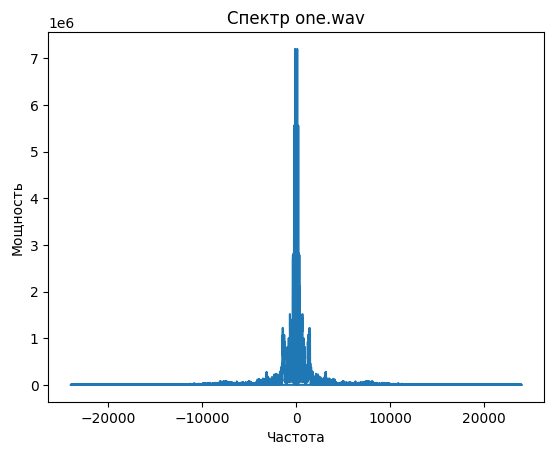

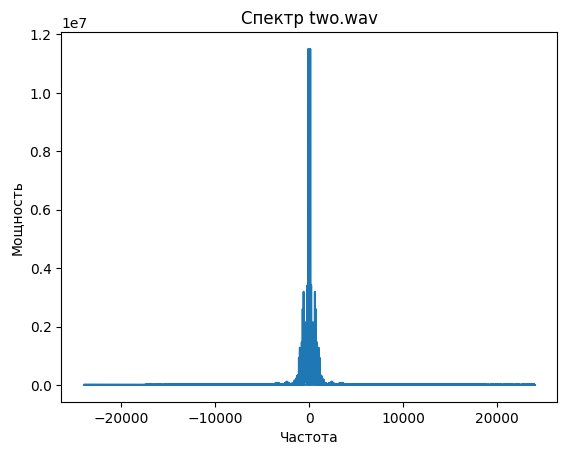

In [6]:
from scipy.fft import fft, fftfreq

duration = len(one) / samplerate_one
N = int(samplerate_one * duration)
yf = fft(one)
xf = fftfreq(N, 1 / samplerate_one)
plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.title('Спектр one.wav')
plt.show()

duration = len(two) / samplerate_two
N = int(samplerate_two * duration)
yf = fft(two)
xf = fftfreq(N, 1 / samplerate_two)
plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.title('Спектр two.wav')
plt.show()

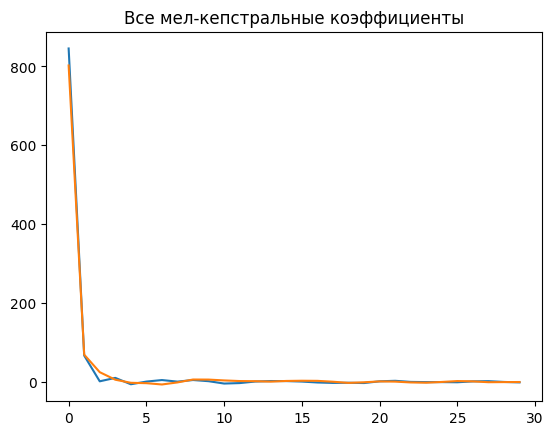

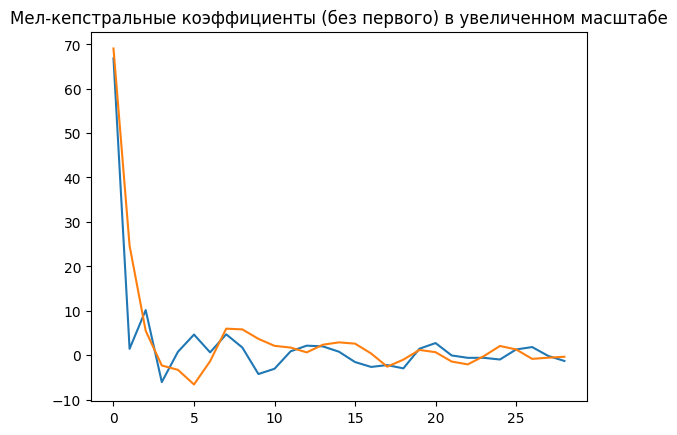

In [7]:
def B_inv(b):
    return 700 * (np.exp(b / 1125) - 1)

def B(b):
    return 1125 * np.log(1 + b / 700)

def get_filter_points(fmin, fmax, mel_filter_num, wav_size, sample_rate=44100):    
    mels = np.linspace(B(fmin), B(fmax), num=mel_filter_num + 2)
    freqs = B_inv(mels)
    
    return np.floor((wav_size + 1) / sample_rate * freqs).astype(int)

def H(k, m, f):
    if k >= f[m - 1] and k < f[m]:
        return (k - f[m - 1]) / (f[m] - f[m - 1])
    if k >= f[m] and k <= f[m + 1]:
        return (f[m + 1] - k) / (f[m + 1] - f[m])
    return 0

mfccs = []
datas = [one, two]
rates = [samplerate_one, samplerate_two]

for i in range(len(datas)):
    x = datas[i]
    X = scipy.fft.fft(datas[i])
    M = 30
    N = len(X)

    filters_points = get_filter_points(0, rates[i] / 2, M, N)

    S = []

    for m in range(1, M + 1):
        Si = 0
        for k in range(N - 1):
            Si += (np.abs(X[k]) ** 2) * H(k, m, filters_points)
        S += [np.log(Si)]
    
    c = []

    for n in range(M):
        ci = 0
        for m in range(M):
            ci += S[m] * np.cos(np.pi * n * (m + 0.5) / M)
        c += [ci]
    mfccs += [c]

for mfcc in mfccs:
    plt.plot(mfcc)
plt.title('Все мел-кепстральные коэффициенты')
plt.show()

for mfcc in mfccs:
    plt.plot(mfcc[1:])
plt.title('Мел-кепстральные коэффициенты (без первого) в увеличенном масштабе')
plt.show()

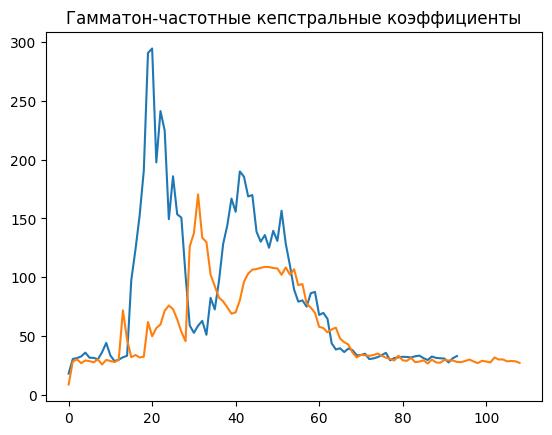

In [8]:
from spafe.features.gfcc import gfcc

for i in range(len(datas)):
    gfccs = gfcc(datas[i], fs=rates[i], num_ceps=1)
    plt.plot(gfccs)
plt.title('Гамматон-частотные кепстральные коэффициенты')
plt.show()

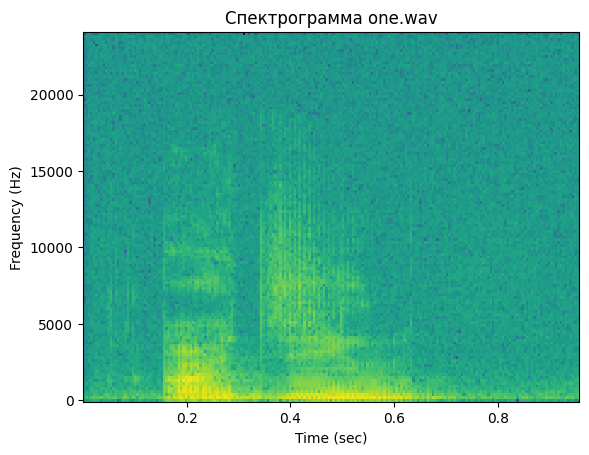

C:\Users\elise\AppData\Local\Temp\ipykernel_17896\1683142241.py:6: RuntimeWarning: divide by zero encountered in log
  lspg = np.log(spgram)


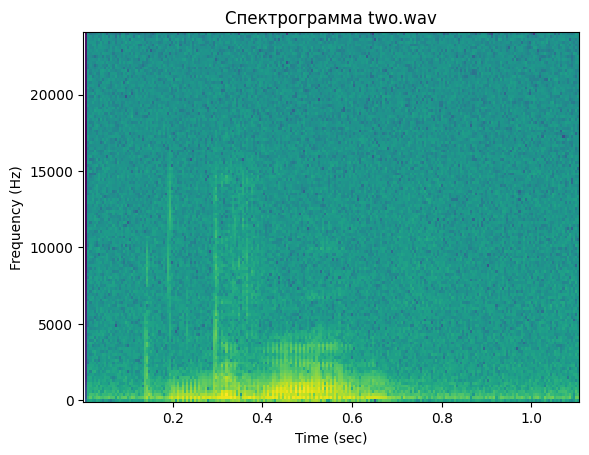

In [9]:
names = ['one.wav', 'two.wav']
for i in range(len(datas)):
    s = rates[i]

    fr, tm, spgram = signal.spectrogram(datas[i],s)
    lspg = np.log(spgram)
    
    plt.pcolormesh(tm,fr,lspg,shading='auto')
    plt.title(f'Спектрограмма {names[i]}')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.show()

Различие между записанными словами "один" и "два" наблюдается почти во всех характеристиках, за исключением спектра, он у них плюс минус похож. Смотря же на другие характеристики (мел-коэффициенты, Гамматон-частотные кепстральные коэффициенты и спектрограмму) видно, что эти звуки разные. В мел-коэффициентах видно у двух этих звуков общий тренд, однако это происходит из-за особенности вычисления самих коэффициентов, нежели схожести звуков.